# INDIAN SIGNBOARD TRANSLATION

In [1]:
cd D:\Signboard project\DATA

D:\Signboard project\DATA


# Load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import cv2
import random

In [3]:
cwd=os.getcwd()

# Load data

In [4]:
def load_images_from_folder(folder):
    images = []
    names  = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            names.append(filename)
    return images,names

In [5]:
images,names=load_images_from_folder(cwd)

In [6]:
len(images)

25

# SOME IMAGES FROM OUR DATASET :

(497, 740, 3)


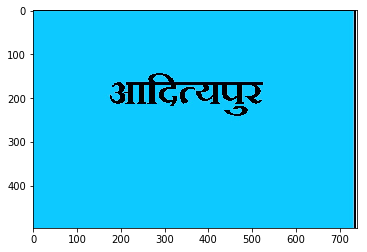

(497, 740, 3)


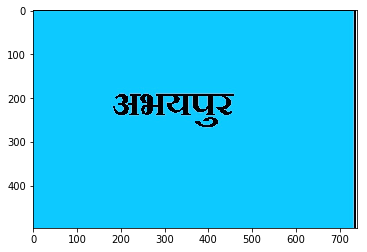

(871, 1297, 3)


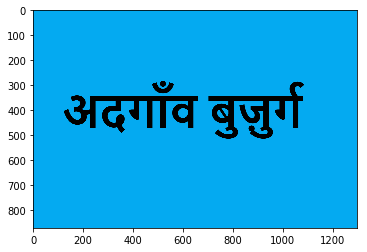

(871, 1297, 3)


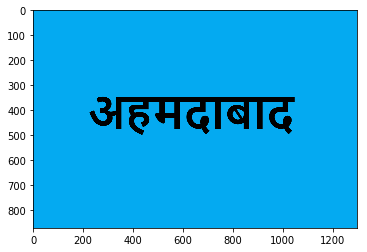

(871, 1297, 3)


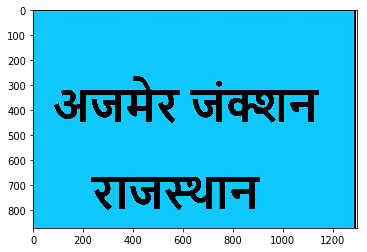

In [7]:
for i in range(5):
    print(images[i].shape)
    plt.imshow(images[i])
    plt.show()

# Finding area containing text :

In [8]:
import os
import shutil

In [9]:
# Utility functions

def crop(img):
    '''img is image read with imread'''
    
    if img.shape[0]>600:
        img=img[150:-30,:-50,:]
    return img    

def show(image):
    cv2.namedWindow('win',cv2.WINDOW_NORMAL)
    cv2.imshow('win',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def erosion(image_binary):
    kernel = np.ones((5,5), np.uint8)
    erode=cv2.erode(image_binary,kernel)
    return erode

In [10]:
# delete crops folder
shutil.rmtree('./crops/')

In [11]:
#create empty crops folder
os.makedirs('./crops', exist_ok=True)

In [12]:
#counter=0
for im,file in zip(images,names):
    #counter+=1
    image=crop(im)    

    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, image_binary) = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
    #show(image_binary)
    
    # eroded image
    erode=erosion(image_binary)
    #show(erode)
    
    # making contours
    im2, contours, hierarchy = cv2.findContours(erode,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    mask=list(hierarchy[0][:,-1]<=-1)   #0,-1
    ids=np.arange(len(hierarchy[0]))
    mid=ids[mask]
    new_cnts=[contours[i] for i in mid]
    cnts_temp=[i for i in new_cnts if cv2.contourArea(i)>1000.0]  
    #len(contours),len(new_cnts),len(cnts_temp)
    
    samp=image.copy()
    
    # Saving images (cropped)
    for sr,i in enumerate(cnts_temp):
        x,y,w,h=cv2.boundingRect(i)
        cv2.imwrite('crops/'+file+str(sr)+'.png',image[y:y+h,x:x+w])
        cv2.rectangle(samp,(x,y),(x+w,y+h),(0,0,255),2)
    cv2.imwrite('samp.png',samp)

# Optical Character Recognition(OCR) for Hindi Words:

In [13]:
import pytesseract

In [14]:
images,names=load_images_from_folder('./crops')

In [15]:
len(images)

25

In [16]:
data=[]
for i in images:
    #plt.imshow(i)
    text = pytesseract.image_to_string(i, lang = 'hin')
    #print(text)
    data.append(text)

# Storing it in a csv for further use

In [17]:
images=np.array(images)
data=np.array(data)
combined = np.vstack((images, data)).T

In [18]:
df=pd.DataFrame(columns=['Image','Text_Extracted'],data=combined)
df.replace('\n',' ',inplace=True,regex=True)

In [19]:
df.head()

,Image,Text_Extracted
0,"[[[18, 204, 252], [18, 204, 252], [18, 204, 25...",आदित्यपुर
1,"[[[18, 204, 252], [18, 204, 252], [18, 204, 25...",अभयपर च्य्फ
2,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अदगाव बुजुर्ग
3,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अहमदाबाद
4,"[[[13, 201, 255], [13, 201, 255], [13, 201, 25...",अजमेर जंक्शन राजस्थान


In [20]:
df.to_csv('D:\Signboard project\hindi_output.csv', sep=',', encoding='utf-8')

# Translation

In [21]:
cd D:\Signboard project

D:\Signboard project


In [22]:
# Imports the Google Cloud client library
from google.cloud import translate

In [23]:
# Instantiates a client
from google.cloud import translate_v2

translate_client = translate_v2.Client.from_service_account_json("key.json", target_language='en')

In [24]:
def translate(text,target='en'):
    # Translates some text into Hindi
    translation = translate_client.translate(text,target_language=target)
    return translation['translatedText']

In [25]:
translated=[]
for i in df['Text_Extracted']:
    translated.append(translate(i))

In [26]:
df['Translated']=translated

In [27]:
df.head()

,Image,Text_Extracted,Translated
0,"[[[18, 204, 252], [18, 204, 252], [18, 204, 25...",आदित्यपुर,Adityapur
1,"[[[18, 204, 252], [18, 204, 252], [18, 204, 25...",अभयपर च्य्फ,Abhayapar Chif
2,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अदगाव बुजुर्ग,Adgaon elderly
3,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अहमदाबाद,Ahmedabad
4,"[[[13, 201, 255], [13, 201, 255], [13, 201, 25...",अजमेर जंक्शन राजस्थान,Ajmer Junction Rajasthan


In [28]:
df.tail()

,Image,Text_Extracted,Translated
20,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",पटना,Patna
21,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",राजपुर सोनारपुर,Rajpur Sonarpur
22,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",रोहतक,Rohtak
23,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",श्री गंगानगर रेलवे स्टेशन,Shri Ganganagar Railway Station
24,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",विशाखापत्तनम,Visakhapatnam


In [29]:
img=df['Image']
text=df['Translated']

In [30]:
len(img),len(text)

(25, 25)

In [31]:
# delete output folder
shutil.rmtree('./DATA/output')

In [32]:
#create empty output folder
os.makedirs('./DATA/output', exist_ok=True)

In [33]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (50,400)
fontScale              = 2
fontColor              = (255,255,255)
lineType               = 2


#ii=img[0]
counter=0
for i,t in zip(img,text):
    counter+=1
    cv2.putText(i,t, bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
    
    #Display the image
    #cv2.imshow("img",ii)

    #Save image
    cv2.imwrite("./DATA/output/out"+str(counter)+".jpg", i)
    #cv2.waitKey(0)

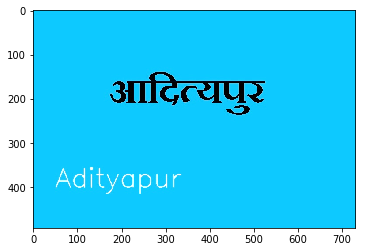

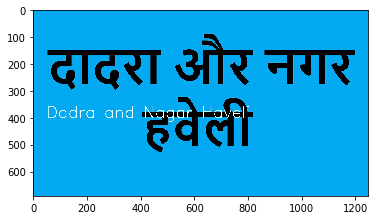

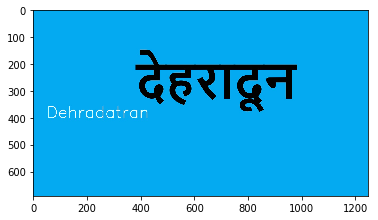

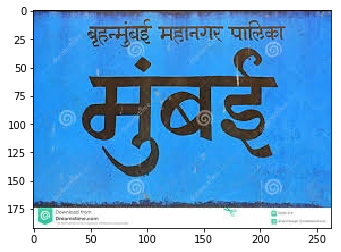

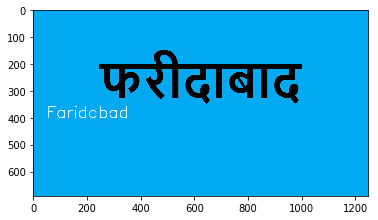

In [34]:
images,names=load_images_from_folder('./DATA/output/')
for i in range(5):
    plt.imshow(images[i])
    plt.show()

In [35]:
df

,Image,Text_Extracted,Translated
0,"[[[18, 204, 252], [18, 204, 252], [18, 204, 25...",आदित्यपुर,Adityapur
1,"[[[18, 204, 252], [18, 204, 252], [18, 204, 25...",अभयपर च्य्फ,Abhayapar Chif
2,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अदगाव बुजुर्ग,Adgaon elderly
3,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अहमदाबाद,Ahmedabad
4,"[[[13, 201, 255], [13, 201, 255], [13, 201, 25...",अजमेर जंक्शन राजस्थान,Ajmer Junction Rajasthan
5,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अमोनी,Amoni
6,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अंकलेश्रर जंक्शन,Ankleshwar junction
7,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",अनूपपुर जंक्शन,Anuppur junction
8,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",बिलासपुर,Bilaspur
9,"[[[4, 170, 241], [4, 170, 241], [4, 170, 241],...",दादरा और नगर हवेली,Dadra and Nagar Haveli
